# Compositionally understanding bAbI6 models

In [1]:
# Imports
import numpy as np
import pandas as pd
from collections import Counter
from pathlib import Path
import torch
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm

from lambeq.backend.grammar import Ty, Diagram, Box, Swap, Id
from lambeq.backend.quantum import Diagram as Circuit, qubit, Id as QId, Discard, Ket, Bra

from utils.following.parser import FollowingParser
from utils.ansatz import DiscardSim4Ansatz
from utils.visualize_quantum import get_bloch_points, plot_points
from utils.babi6.vocabulary import PEOPLE, OBJECTS, LOCATIONS

SAVE_DIR = Path("./results/babi6").resolve()
SAVE_DIR.parent.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "bAbI-6 model"

SAVE_DIR

PosixPath('/Users/tiffany.duneau/PycharmProjects/QDisCoCirc_Following_Showcase/tutorials/results/babi6')

In [2]:
# Vegalite config for displaying figures
def VegaLite(spec):
    bundle = {}
    bundle['application/vnd.vegalite.v4+json'] = spec
    display(bundle, raw=True)

true, false, null = True, False, None

config = {
  "legend": {
    "fillColor": "#fffd",
    "padding": 10,
    "strokeColor": "#eeeeee",
    "labelFontSize": 12,
  },
  "axis": {
      "labelFontSize": 12,
      "titleFontSize": 14,
  },
  "title": {
      "fontSize": 16,
      "anchor": "center",
  },
  "header": {
    "titleFontSize": 14,
    "titleFontWeight": "bold",
    "labelFontSize": 16,
    "labelFontWeight": "normal"
  }
}

### Get the trained parameters

In [262]:
# load the saved weights
with open(SAVE_DIR / "training" / "model.lt", "rb") as f:
    checkpoint = pickle.load(f)

symbols = checkpoint["model_symbols"]
weights = checkpoint["model_weights"].detach().numpy()
len(symbols), len(weights)

(393, 393)

In [4]:
parser = FollowingParser(with_axioms=True, n_directions=4)
ansatz = DiscardSim4Ansatz(
    ob_map={Ty('n'): 1},
    n_layers=3,
    discard=True,
    n_ancillas={parser.follows: 1, parser.goes_opdir: 1},
)

In [5]:
# convert = lambda diag: ansatz(diag).lambdify(*symbols)(*weights)

def lambdify(diag): 
    return diag.lambdify(*symbols)(*weights)

def lambdeval(diag):
    return torch.as_tensor(ansatz(diag).lambdify(*symbols)(*weights).eval(), dtype=torch.cdouble)

def lambdeval_no_a(diag):
    return torch.as_tensor(diag.lambdify(*symbols)(*weights).eval(), dtype=torch.cdouble)

list(zip(symbols, weights))

[(Andrew__n_0, 0.7544399),
 (Andrew__n_1, 0.27539995),
 (Andrew__n_2, 0.9965172),
 (Bill__n_0, 0.06748587),
 (Bill__n_1, 0.23362862),
 (Bill__n_2, 0.25498915),
 (Clara__n_0, 0.750895),
 (Clara__n_1, 0.7409938),
 (Clara__n_2, 0.22861652),
 (Daniel__n_0, 0.17813511),
 (Daniel__n_1, 0.2365994),
 (Daniel__n_2, 0.39973733),
 (Denise__n_0, 0.22308815),
 (Denise__n_1, 0.75617355),
 (Denise__n_2, 0.22303985),
 (Eric__n_0, 0.23891911),
 (Eric__n_1, 0.25970668),
 (Eric__n_2, 0.019745968),
 (Fred__n_0, 0.21747811),
 (Fred__n_1, 0.24315715),
 (Fred__n_2, 0.57571805),
 (Gillian__n_0, 0.8277713),
 (Gillian__n_1, 0.28180665),
 (Gillian__n_2, 0.21204095),
 (Heidi__n_0, 0.8082349),
 (Heidi__n_1, 0.23711996),
 (Heidi__n_2, 0.2652859),
 (John__n_0, 0.3062781),
 (John__n_1, 0.3047911),
 (John__n_2, 0.7356289),
 (Mary__n_0, 0.76292694),
 (Mary__n_1, 0.77183115),
 (Mary__n_2, 0.7680206),
 (Sandra__n_0, 0.23543963),
 (Sandra__n_1, 0.25340956),
 (Sandra__n_2, 0.3624619),
 ([\back]_n_n_0, 0.40703753),
 ([\back

### Define the model boxes

In [6]:
n = Ty("n")
N = Id(n)
INIT0 = Box("INIT_0", Ty(), n)
DISCARD = Box("DISCARD", n, Ty())

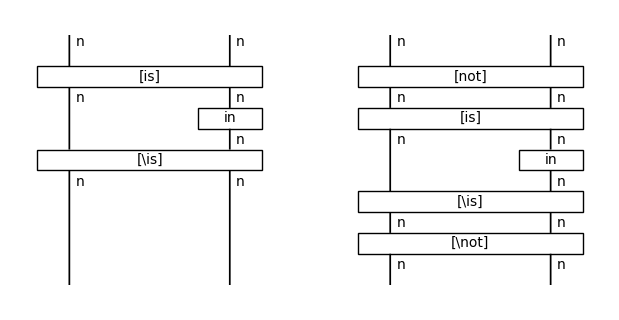

In [7]:
# questions
q_in = Box('in', n, n)
q_is = {
    "top":    Box('[is]',   n @ n, n @ n),
    "bottom": Box('[\\is]', n @ n, n @ n),
}
q_not = {
    "top":    Box('[not]',   n @ n, n @ n),
    "bottom": Box('[\\not]', n @ n, n @ n),
}
is_in = q_is["top"] >> n @ q_in >> q_is["bottom"]
is_not_in = q_not["top"] >> is_in >> q_not["bottom"]

questions = {
    "is in": is_in,
    "is not in": is_not_in,
}
(is_in @ is_not_in).draw(figsize=(6,3))

In [8]:
people = {name: Box(name, Ty(), n) for name in PEOPLE}
locations = {name: Box(name, Ty(), n) for name in LOCATIONS}
objects = {name: Box(name, Ty(), n) for name in OBJECTS}
"people", people.keys(), "locations", locations.keys(), "objects", objects.keys()

('people',
 dict_keys(['Andrew', 'Bill', 'Clara', 'Denise', 'Eric', 'Fred', 'Gillian', 'Heidi', 'Mary', 'Sandra', 'Daniel', 'John']),
 'locations',
 dict_keys(['kitchen', 'office', 'hallway', 'bedroom', 'garden', 'bathroom', 'cinema', 'park']),
 'objects',
 dict_keys(['apple', 'football', 'milk', 'slippers']))

In [9]:
move = {
    "travelled": Box('travelled', n, n),
    "journeyed": Box('journeyed', n, n),
    "moved": Box('moved', n, n),
    "went": Box('went', n, n),
}
back = {
    "top":    Box('[back]',   n, n),
    "bottom": Box('[\\back]', n, n),
}
to = {
    "top":    Box('[to]',   n @ n, n @ n),
    "bottom": Box('[\\to]', n @ n, n @ n),
}
"move", move.keys(), "back", "to"

('move', dict_keys(['travelled', 'journeyed', 'moved', 'went']), 'back', 'to')

In [10]:
down = {
    "top":    Box('[down]',   n @ n, n @ n),
    "bottom": Box('[\\down]', n @ n, n @ n),
}
up = {
    "top":    Box('[up]',   n @ n, n @ n),
    "bottom": Box('[\\up]', n @ n, n @ n),
}
grab = {
    "grabbed": Box('grabbed', n @ n, n @ n),
    "got": Box('got', n @ n, n @ n),
    "took": Box('took', n @ n, n @ n),
    "picked": Box('picked', n @ n, n @ n),
}
drop = {
    "put": Box('put', n @ n, n @ n),
    "left": Box('left', n @ n, n @ n),
    "discarded": Box('discarded', n @ n, n @ n),
    "dropped": Box('dropped', n @ n, n @ n),
}
"grab", grab.keys(), "drop", drop.keys(), "up", "down"

('grab',
 dict_keys(['grabbed', 'got', 'took', 'picked']),
 'drop',
 dict_keys(['put', 'left', 'discarded', 'dropped']),
 'up',
 'down')

### Single qubit states and boxes

In [11]:
get_col = {
    "People": "b",
    "Locations": "c", 
    "Objects": "r",
}

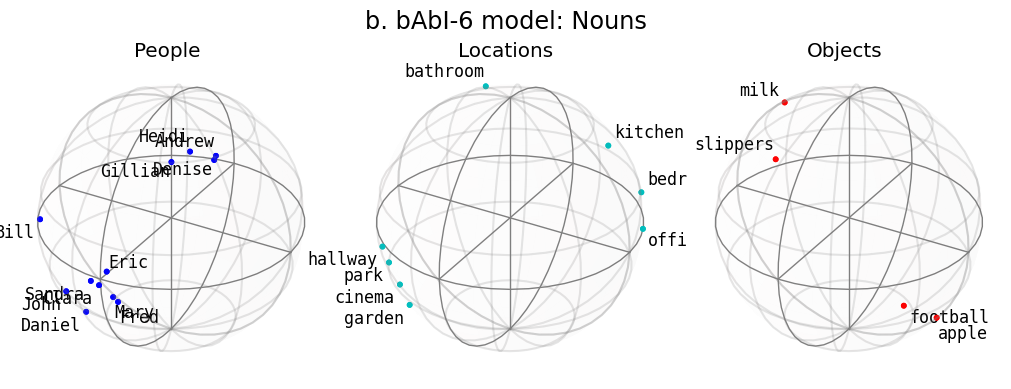

In [261]:
# Combined single qubit images
fig = plt.figure(figsize=[10, 4], layout='constrained')
subfigs = fig.subfigures(1, 3, wspace=0.05)

fig.suptitle(f"b. {MODEL_NAME}: Nouns", fontsize="xx-large")

# states
for i, (group, group_name) in enumerate(zip([people, locations, objects], ["People", "Locations", "Objects"])):
    subfig = subfigs[i]

    ax = subfig.add_subplot(1, 1, 1, projection='3d')
    plot_points(
        [lambdeval(diag) for diag in group.values()],
        fig=subfig,
        axes=ax,
        colors=[get_col[group_name] for _ in range(len(group))],
        annotations=[
            (
                get_bloch_points([lambdeval(noun)])[0],
                {"text": key, "fontfamily": "monospace"}
            )
            for key, noun in group.items()
        ],
    )
    ax.axis('off')
    ax.set_title(f"{group_name}", fontsize="x-large")

In [14]:
# To be determined from the above images.
# If more than one qubit used, can be obtained from the full comparison matrix instead.
person_basis = ["Andrew", "Sandra"]
location_basis = ["bedroom", "park"]
object_basis = ["milk", "football"]

In [15]:
# Define basic comparison operations
CAP = (Ket(0) @ Ket(0)).H(0).CX(0, 1)
CUP = CAP.dagger()

def compare_boxes(box1, box2):
    caps = QId().tensor(*[CAP for _ in box2.dom])
    cups = QId().tensor(*[CUP for _ in box2.dom])

    # Permute the wires so they line up properly with the cod
    perm = [i for i in range(0, len(box2.dom)* 2, 2)] + [i for i in range(1, 1+ len(box2.dom)* 2, 2)]
    swaps = caps.permutation(caps.cod, perm)

    # overlap the boxes
    if box1 is not None:
        boxes = (box1 >> box2.dagger()) @ box2.dom
    else:
        boxes = box2 @ box2.dom
    
    return caps >> swaps >> ansatz(boxes) >> swaps.dagger() >> cups @ (Ket(0) >> Discard())

def compare_states(box1, box2):
    return ansatz(box1 >> box2.dagger()) @ (Ket(0) >> Discard())

In [16]:
# Overlap between nouns
noun_comparisons = []

all_nouns = {
    **people,
    **locations,
    **objects,
}
for pair in tqdm(all_nouns.keys()):
    for pair1 in all_nouns.keys():
        diag = compare_states(all_nouns[pair], all_nouns[pair1])
        res = lambdeval_no_a(diag)
        noun_comparisons.append((pair, pair1, res))

nouns_overlap_df = pd.DataFrame(noun_comparisons, columns=["pair1", "pair2", "overlap"])
nouns_overlap_df["overlap_real"] = [o.real.item() for o in nouns_overlap_df.overlap]
nouns_overlap_df["method"] = "state"
nouns_overlap_df

100%|██████████| 24/24 [00:01<00:00, 19.27it/s]


,pair1,pair2,overlap,overlap_real,method
0,Andrew,Andrew,"tensor(1.0000-3.1241e-17j, dtype=torch.complex...",1.000000,state
1,Andrew,Bill,"tensor(0.3689+2.4487e-17j, dtype=torch.complex...",0.368897,state
2,Andrew,Clara,"tensor(0.0075+1.5711e-19j, dtype=torch.complex...",0.007517,state
3,Andrew,Denise,"tensor(0.9995+6.1073e-18j, dtype=torch.complex...",0.999536,state
4,Andrew,Eric,"tensor(0.0058-3.4989e-18j, dtype=torch.complex...",0.005765,state
...,...,...,...,...,...
571,slippers,park,"tensor(0.7513+8.9469e-17j, dtype=torch.complex...",0.751285,state
572,slippers,apple,"tensor(0.0790+3.3918e-17j, dtype=torch.complex...",0.078984,state
573,slippers,football,"tensor(0.4121+3.1867e-17j, dtype=torch.complex...",0.412137,state
574,slippers,milk,"tensor(0.7540-1.1128e-17j, dtype=torch.complex...",0.753960,state


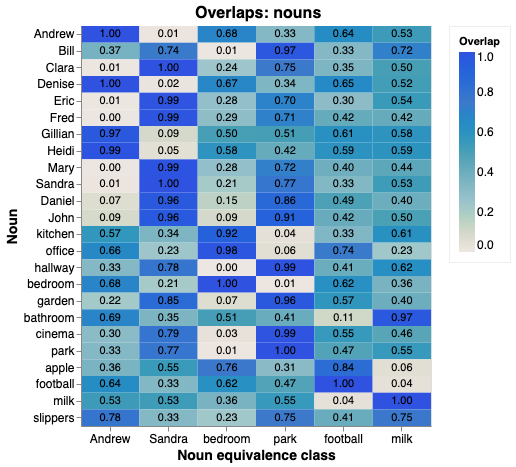

In [17]:
VegaLite({
    "data": {"values": nouns_overlap_df.loc[:, ["pair1", "pair2", "overlap_real"]].to_dict("records")},
    "title": "Overlaps: nouns",
    "transform": [
        {"filter": f"indexof({person_basis + location_basis + object_basis}, datum.pair1) >= 0"},
        {"as":"overlap_real_rounded", "calculate": "format(datum.overlap_real, '.2f')"},
    ],
    "encoding": {
        "x": {"field": "pair1", "type": "nominal", "sort": "", "title": "Noun equivalence class", "axis": {"labelAngle": 0}},
        "y": {"field": "pair2", "type": "nominal", "sort": "", "title": "Noun"},
    },
    "layer": [
        {
            "mark": "rect",
            "encoding": {
                "color": {
                    "field": "overlap_real", 
                    "type": "quantitative", 
                    "title": "Overlap", 
                    "scale": {
                        "domain": [0,1],
                        "scheme": [
                            "#EDE7E3",
                            "#9BC3CC",
                            "#489FB5",
                            "#3C79CB",
                            "#2F52E0",
                        ]
                    }
                },
            }
        },
        {
            "mark": "text",
            "encoding": {
                "text": {"field": "overlap_real_rounded"},
            }
        },
    ],
    "width": 350,
    "height": 400,
    
    "config": config,
})

In [18]:
# overlaps between synonyms via map-state duality
movement_comparisons = []

for pair in tqdm(move.keys()):
    for pair1 in move.keys():
        diag = compare_boxes(move[pair], move[pair1])
        res = lambdeval_no_a(diag)
        movement_comparisons.append((pair, pair1, res))

    for pair2 in ["went", "moved"]:
        diag = compare_boxes(move[pair], back["top"] >> move[pair2] >> back["bottom"])
        res = lambdeval_no_a(diag)
        movement_comparisons.append((pair, pair2 + " back", res))

movement_overlap_df = pd.DataFrame(movement_comparisons, columns=["pair1", "pair2", "overlap"])
movement_overlap_df["overlap_real"] = [o.real.item() for o in movement_overlap_df.overlap]
movement_overlap_df["method"] = "box"
movement_overlap_df

100%|██████████| 4/4 [00:00<00:00, 31.06it/s]


,pair1,pair2,overlap,overlap_real,method
0,travelled,travelled,"tensor(1.0000-1.6258e-17j, dtype=torch.complex...",1.000000,box
1,travelled,journeyed,"tensor(0.9364+4.0287e-17j, dtype=torch.complex...",0.936366,box
2,travelled,moved,"tensor(0.1076-0.j, dtype=torch.complex128)",0.107616,box
3,travelled,went,"tensor(0.2260+1.3194e-17j, dtype=torch.complex...",0.225984,box
4,travelled,went back,"tensor(0.7741-3.0526e-18j, dtype=torch.complex...",0.774129,box
5,travelled,moved back,"tensor(0.6357-6.6387e-17j, dtype=torch.complex...",0.635666,box
6,journeyed,travelled,"tensor(0.9364-8.0574e-17j, dtype=torch.complex...",0.936366,box
7,journeyed,journeyed,"tensor(1.0000-5.1174e-17j, dtype=torch.complex...",1.000000,box
8,journeyed,moved,"tensor(0.0133-8.0162e-19j, dtype=torch.complex...",0.013346,box
9,journeyed,went,"tensor(0.1158+4.7228e-18j, dtype=torch.complex...",0.115815,box


In [260]:
movement_comparisons_id = []

for pair1 in move.keys():
    diag = compare_boxes(None, move[pair1])
    res = lambdeval_no_a(diag)
    movement_comparisons_id.append(("ID", pair1, res))

for pair2 in ["went", "moved"]:
    diag = compare_boxes(None, back["top"] >> move[pair2] >> back["bottom"])
    res = lambdeval_no_a(diag)
    movement_comparisons_id.append(("ID", pair2 + " back", res))

movement_overlap_id_df = pd.DataFrame(movement_comparisons_id, columns=["pair1", "pair2", "overlap"])
movement_overlap_id_df["overlap_real"] = [o.real.item() for o in movement_overlap_id_df.overlap]
movement_overlap_id_df["method"] = "box"
movement_overlap_id_df

,pair1,pair2,overlap,overlap_real,method
0,ID,travelled,"tensor(0.0510-6.2672e-18j, dtype=torch.complex...",0.050986,box
1,ID,journeyed,"tensor(0.0197+0.j, dtype=torch.complex128)",0.019655,box
2,ID,moved,"tensor(0.0124-0.j, dtype=torch.complex128)",0.012364,box
3,ID,went,"tensor(0.1486-0.j, dtype=torch.complex128)",0.148613,box
4,ID,went back,"tensor(0.1713-6.4608e-18j, dtype=torch.complex...",0.171251,box
5,ID,moved back,"tensor(0.5447+2.5607e-18j, dtype=torch.complex...",0.544736,box


In [143]:
movement_basis = ["moved", "travelled"]
# movement_basis = list(move.keys()) + ["went back", "moved back"]

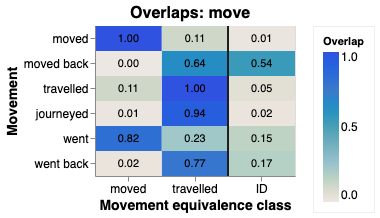

In [144]:
VegaLite({
    "data": {"values": pd.concat([movement_overlap_df, movement_overlap_id_df], axis=0).loc[:, ["pair1", "pair2", "overlap_real"]].to_dict("records")},
    "title": f"Overlaps: move",
    "transform": [
        {"filter": f"indexof({movement_basis + ['ID']}, datum.pair1) >= 0"},
        {"as":"overlap_real_rounded", "calculate": "format(datum.overlap_real, '.2f')"},
    ],
    "encoding": {
        "x": {"field": "pair1", "type": "nominal", "sort": ["moved"], "title": "Movement equivalence class", "axis": {"labelAngle": 0}},
        "y": {"field": "pair2", "type": "nominal", "sort": ["moved", "moved back"], "title": "Movement"},
    },
    "width": 200,
    "height": 150,
    "layer": [
        {
            "mark": "rect",
            "encoding": {
                "color": {
                    "field": "overlap_real", 
                    "type": "quantitative", 
                    "title": "Overlap", 
                    "scale": {
                        "domain": [0,1],
                        "scheme": [
                            "#EDE7E3",
                            "#9BC3CC",
                            "#489FB5",
                            "#3C79CB",
                            "#2F52E0",
                        ]
                    }
                },
            }
        },
        {
            "mark": "text",
            "encoding": {
                "text": {"field": "overlap_real_rounded"},
            }
        },
        {
            "mark": {"type": "rule"},
            "encoding": {
                "x": {"datum": "ID"},
                "y": {},
                "xOffset": {"value": 0},
                "color": {"value": "#1C1C20"},
            }
        }
    ],
    "config": config,
})

#### Grab (axioms)

In [24]:
grab_boxes = {
    'picked up': up["top"] >> grab["picked"] >> up["bottom"],
    'grabbed': grab["grabbed"], 
    'got': grab["got"],
    'took': grab["took"], 
    'put down': down["top"] >> drop["put"] >> down["bottom"],
    'left': drop["left"], 
    'discarded': drop["discarded"],
    'dropped': drop["dropped"],
}

In [25]:
grab_axioms = []
for desc, box in grab_boxes.items():
    for desc2, box2 in tqdm(grab_boxes.items(), desc=f"computing ({desc}, grab)"):
        res_box = lambdeval_no_a(compare_boxes(box, box2))
        grab_axioms.append((desc, desc2, res_box, "box"))

for desc, box in tqdm(grab_boxes.items(), desc="computing (grab, ID)"):
    res_box = lambdeval_no_a(compare_boxes(None, box))
    grab_axioms.append(("ID", desc, res_box, "box"))

grab_axioms_df = pd.DataFrame(grab_axioms, columns=["state1", "state2", "overlap", "method"])
grab_axioms_df["overlap_real"] = [o.real.item() for o in grab_axioms_df.overlap]
grab_axioms_df

computing (grab, ID): 100%|██████████| 8/8 [00:00<00:00, 63.34it/s]


,state1,state2,overlap,method,overlap_real
0,picked up,picked up,"tensor(1.0000-2.2217e-17j, dtype=torch.complex...",box,1.000000
1,picked up,grabbed,"tensor(0.1153-6.5429e-18j, dtype=torch.complex...",box,0.115256
2,picked up,got,"tensor(0.0565+2.1783e-17j, dtype=torch.complex...",box,0.056527
3,picked up,took,"tensor(0.0751+7.7380e-18j, dtype=torch.complex...",box,0.075054
4,picked up,put down,"tensor(0.0001+9.6782e-19j, dtype=torch.complex...",box,0.000112
...,...,...,...,...,...
67,ID,took,"tensor(0.1334+8.5681e-21j, dtype=torch.complex...",box,0.133376
68,ID,put down,"tensor(0.0489+2.3400e-18j, dtype=torch.complex...",box,0.048854
69,ID,left,"tensor(0.1166+1.2928e-17j, dtype=torch.complex...",box,0.116562
70,ID,discarded,"tensor(0.0596+5.6296e-18j, dtype=torch.complex...",box,0.059553


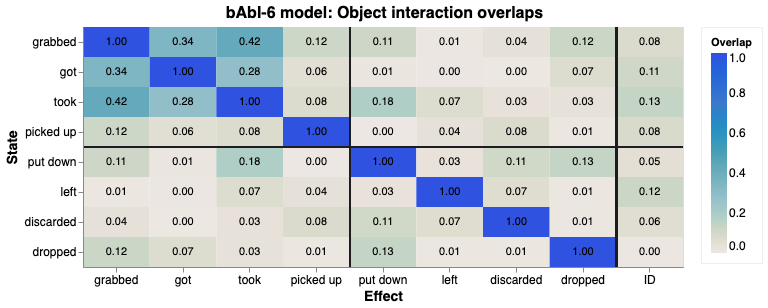

In [26]:
VegaLite({
    "data": {"values": grab_axioms_df.loc[:, ["state1", "state2", "overlap_real", "method"]].to_dict("records")},
    "transform": [
        {"as":"overlap_real_rounded", "calculate": "format(datum.overlap_real, '.2f')"},
    ],
    "title": f"{MODEL_NAME}: Object interaction overlaps",
    # "facet": {"field": "movement", "title": ""},
    "columns": 1,
    # "resolve": {"axis": {"x": "independent"}},
    # "spec": {
        "width": 600,
        "height": 240,
        "encoding": {
            "x": {"field": "state1", "title": "Effect", "type": "nominal", "axis": {"labelAngle": 0}, "sort": [
                'grabbed', 'got', 'took', 'picked up',
            ]},
            "y": {"field": "state2", "title": "State", "type": "nominal", "sort": [
               'grabbed', 'got', 'took', 'picked up',
            ]},
        },
        "layer": [
            {
                "mark": "rect",
                "encoding": {
                    "color": {
                        "field": "overlap_real", 
                        "type": "quantitative", 
                        "title": "Overlap", 
                        "scale": {
                            "domain": [0,1],
                            "scheme": [
                                "#EDE7E3",
                                "#9BC3CC",
                                "#489FB5",
                                "#3C79CB",
                                "#2F52E0",
                            ]
                        },
                        # "condition": {
                        #     "test": "datum.overlap_real < 0.5 && datum.overlap_real > 0.0625",
                        #     "value": "#FFFFFF",
                        # },
                    },
                }
            },
            {
                "mark": "text",
                "encoding": {
                    "text": {"field": "overlap_real_rounded"},
                }
            },
            {
                "mark": {"type": "rule", "color": "#1C1C20", "strokeWidth": 1},
                "encoding": {
                    "y": {"datum": "put down"},
                    "yOffset": {"value": 0},
                    "x": {},
                    "xOffset": {},
                }
            },
            {
                "mark": {"type": "rule", "color": "#1C1C20", "strokeWidth": 1},
                "encoding": {
                    "x": {"datum": "put down"},
                    "xOffset": {"value": 0},
                    "y": {},
                }
            },
            # {
            #     "mark": {"type": "rule", "color": "#1C1C20", "strokeWidth": 2},
            #     "encoding": {
            #         "y": {"datum": "A is in p"},
            #         "yOffset": {"value": 0},
            #         "x": {},
            #         "xOffset": {},
            #     }
            # },
            {
                "mark": {"type": "rule", "color": "#1C1C20", "strokeWidth": 2},
                "encoding": {
                    "x": {"datum": "ID"},
                    "xOffset": {"value": 0},
                    "y": {},
                }
            },
        ],
    # },
    "config": config,
})

From the above, we see that the boxes have very small overlap with respect to each other, however the task does not imply high *absolute* overlap, but merely high overlap relative to the questions.

In the following section, we consider these relative overlaps instead, and test some axioms that the model should have learnt.

### All axioms, factored through question 'basis'

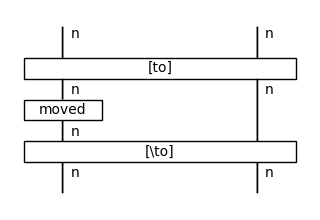

In [71]:
wrap_to = lambda movement: to["top"] >> move[movement] @ N >> to["bottom"]

move_basis = {movement: wrap_to(movement) for movement in movement_basis}
move_basis[movement_basis[0]].draw(figsize=(3,2))

In [145]:
# Initial states
A = people[person_basis[0]]
C = people[person_basis[-1]]
p = locations[location_basis[0]]
k = locations[location_basis[-1]]

# Grab diag fragments
# A grab o. A moves p
Ao_Ap = lambda key, key2="grabbed": (
       (grab_boxes[key2] @ N).permuted([1,0,2]) \
    >> (N @ move_basis[key]).permuted([1,0,2])
)
# A moves p. A grab o
Ap_Ao = lambda key, key2="grabbed": (
    (N @ N @ N).permuted([0,2,1]) \
    >> (move_basis[key] @ N).permuted([0,2,1]) \
    >> grab_boxes[key2 or key] @ N
)
Ao = lambda key: grab_boxes[key]

# Move diag fragments
# A move p.
Ap = lambda key: move_basis[key]

# A moves p. A moves k
Ak_Ap = lambda key, key2=None: (
       (move_basis[key] @ N).permuted([1,0,2]) \
    >> (N @ move_basis[key2 or key]).permuted([1,0,2])
)
# A moves k. A moves p
Ap_Ak = lambda key, key2=None: (
    (N @ N @ N).permuted([0,2,1]) \
    >> (move_basis[key] @ N).permuted([0,2,1]) \
    >> move_basis[key2 or key] @ N
)
# A moves p. C moves p
Ap_Cp = lambda key, key2=None: (
    (N @ N @ N).permuted([0,2,1]) \
    >> (move_basis[key] @ N).permuted([0,2,1]) \
    >> N @ move_basis[key2 or key]
)
# C moves p. A moves c
Cp_Ap = lambda key, key2=None: (
    (N @ move_basis[key]).permuted([0,2,1]) \
    >> (move_basis[key2 or key] @ N).permuted([0,2,1])
)

In [193]:
diags = {
    # Upgrade 2q states to have a 3rd discarded qubit to match 3q states.
    "Ap":    lambda x, y, z: (N @ N @ N).permuted([0,2,1]) >> Ap(x) @ DISCARD, 
    "Ak":    lambda x, y, z: Ap(x) @ N >> N @ DISCARD @ N,
    "Cp":    lambda x, y, z: N @ Ap(x) >> N @ DISCARD @ N,
    "Ap_Ap": lambda x, y, z: (N @ N @ N).permuted([0,2,1]) >> Ap(x) @ DISCARD >> Ap(y),
    "Ak_Ap": lambda x, y, z: Ak_Ap(x, y) >> N @ DISCARD @ N,
    "Ap_Ak": lambda x, y, z: Ap_Ak(x, y) >> N @ DISCARD @ N, 
    "Ap_Cp": lambda x, y, z: Ap_Cp(x, y) >> N @ DISCARD @ N, 
    "Cp_Ap": lambda x, y, z: Cp_Ap(x, y) >> N @ DISCARD @ N,
    "Ap_Ap_Ap": lambda x, y, z: (N @ N @ N).permuted([0,2,1]) >> Ap(x) @ DISCARD >> Ap(y) >> Ap(y),
    "ID":     lambda x, y, z: N @ DISCARD @ N,
    "init_C": lambda x, y, z: people[x] @ people[y] @ locations[z],  # A @ C @ p,
    "init_k": lambda x, y, z: people[x] @ locations[y] @ locations[z],  # A @ k @ p,
    "init_o": lambda x, y, z: people[x] @ objects[y] @ locations[z],   # feed it the object state since there isn't a canonical one

    "Ao":    lambda x, y, z: Ao(x) @ N >> N @ DISCARD @ N,
    "Ao_Ap": lambda x, y, z: Ao_Ap(x, y) >> N @ DISCARD @ N,
    "Ap_Ao": lambda x, y, z: Ap_Ao(x, y) >> N @ DISCARD @ N, 
}
questions = {
    f"{person} is{' not' if op == is_not_in else ''} in the {location}": {
        "diag": people[person] @ locations[location] >> op,
        "person": person, 
        "location": location,
        "is_in": op == is_in,
    }
    for person in person_basis
    for location in location_basis
    for op in [is_in, is_not_in]
}
questions.keys()

dict_keys(['Andrew is in the bedroom', 'Andrew is not in the bedroom', 'Andrew is in the park', 'Andrew is not in the park', 'Sandra is in the bedroom', 'Sandra is not in the bedroom', 'Sandra is in the park', 'Sandra is not in the park'])

Ap @ Ak @ Ak_Ap


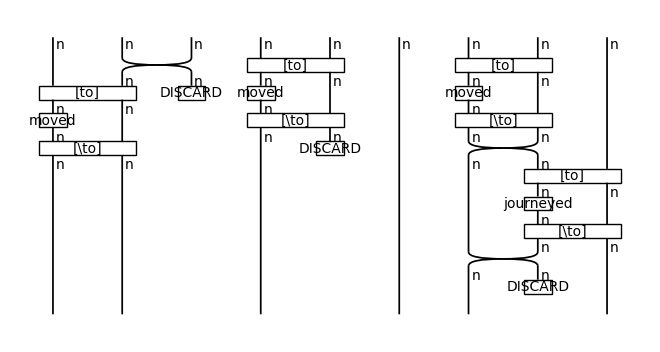

In [147]:
print("Ap @ Ak @ Ak_Ap")
(
    diags["Ap"]("moved", "journeyed") 
    @ diags["Ak"]("moved", "journeyed") 
    @ diags["Ak_Ap"]("moved", "journeyed")
).draw()

In [195]:
all_axioms_overlaps = []
for desc1, desc2, axiom in tqdm([
    ("Ap", "Ap_Ap", "idempotence"),
    ("Ak_Ap", "Ap_Ak", "visit ordering matters"), 
    ("Ak_Ap", "Ap", "forgetfulness I"), 
    ("Ak_Ap", "Ak", "forgetfulness II"), 
    ("Cp_Ap", "Ap_Cp", "multiple people in a single location I"),
    ("Ap", "Ap_Cp", "multiple people in a single location II"),
    ("Ap", "Ak", "distinguishable locations"),
    ("Ap", "Cp", "distinguishable people"),
    ("Ap", "ID", "moving matters"),
], desc="axioms"):
    for ques, question in questions.items():
        for movement in move_basis:
            movement1 = movement2 = movement
            qdiag = question["diag"].dagger()
            diag1 = ansatz(diags[desc1](movement1, movement2, None) >> qdiag)
            diag2 = ansatz(diags[desc2](movement1, movement2, None) >> qdiag)
            res = lambdeval_no_a(diag1.dagger() >> diag2)
            
            all_axioms_overlaps.append((movement1, movement2, desc1, desc2, ques, axiom, res, question["person"], question["location"]))

axioms: 100%|██████████| 9/9 [00:11<00:00,  1.32s/it]


In [200]:
for desc1, desc2, axiom in (
    ("init_k", "ID", "Base case: A is not in p"),
    ("init_k", "Ap", "Base case: A is in p"),
):
    for ques, question in tqdm(questions.items(), desc=axiom):
        for movement in move_basis:
            movement1 = movement2 = movement
            qdiag = question["diag"].dagger()
            diag = ansatz(
                diags[desc1](question["person"], question["location"], question["location"]) 
                >> diags[desc2](movement1, movement2, None)
                >> qdiag
            )
            res = lambdeval_no_a(diag)
            
            all_axioms_overlaps.append((movement1, movement2, desc1, desc2, ques, axiom, res, question["person"], question["location"]))

for desc1, desc2, axiom in (
    ("init_o", "Ao", "Base: A is not in p II"),
):
    for ques, question in tqdm(questions.items(), desc=axiom):
        for movement in grab_boxes.keys():
            for obj in object_basis:
                movement1 = movement2 = movement
                qdiag = question["diag"].dagger()
                diag = ansatz(
                    diags[desc1](person, obj, location) 
                    >> diags[desc2](movement1, movement2, None)
                    >> qdiag
                )
                res = lambdeval_no_a(diag)
                
                all_axioms_overlaps.append((obj, movement2, desc1, desc2, ques, axiom, res, question["person"], question["location"]))

Base: A is not in p II: 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


In [201]:
for desc1, desc2, axiom in [
    ("Ap", "Ao_Ap", "irrelevance"),
    ("Ap_Ao", "Ao_Ap", "commutativitiy"),
]:
    for ques, question in tqdm(questions.items(), desc=axiom):
        for movement in move_basis:
            for grab in grab_boxes.keys():
                qdiag = question["diag"].dagger()
                diag1 = ansatz(diags[desc1](movement, grab, None) >> qdiag)
                diag2 = ansatz(diags[desc2](movement, grab, None) >> qdiag)
                res = lambdeval_no_a(diag1.dagger() >> diag2)
                
                all_axioms_overlaps.append((movement, grab, desc1, desc2, ques, axiom, res, question["person"], question["location"]))

commutativitiy: 100%|██████████| 8/8 [00:11<00:00,  1.50s/it]


In [202]:
all_axioms_overlaps_df = pd.DataFrame(
    all_axioms_overlaps,
    columns=["movement", "movement2", "diag1", "diag2", "ques", "axiom", "overlap", "person", "location"]
)
all_axioms_overlaps_df["states"] = [
    f"({s1}, {s2})"
    for s1, s2 in zip(all_axioms_overlaps_df.diag1, all_axioms_overlaps_df.diag2)
]
all_axioms_overlaps_df["overlap_real"] = [o.real.item() for o in all_axioms_overlaps_df.overlap]
all_axioms_overlaps_df = all_axioms_overlaps_df.drop_duplicates()

all_axioms_overlaps_df.to_csv(SAVE_DIR / f"axiom_overlaps.csv")

all_axioms_overlaps_df

,movement,movement2,diag1,diag2,ques,axiom,overlap,person,location,states,overlap_real
0,moved,moved,Ap,Ap_Ap,Andrew is in the bedroom,idempotence,"tensor(1.3476-1.5834e-16j, dtype=torch.complex...",Andrew,bedroom,"(Ap, Ap_Ap)",1.347650
1,journeyed,journeyed,Ap,Ap_Ap,Andrew is in the bedroom,idempotence,"tensor(1.0680-2.2216e-16j, dtype=torch.complex...",Andrew,bedroom,"(Ap, Ap_Ap)",1.067981
2,moved,moved,Ap,Ap_Ap,Andrew is not in the bedroom,idempotence,"tensor(0.9545-2.1390e-16j, dtype=torch.complex...",Andrew,bedroom,"(Ap, Ap_Ap)",0.954501
3,journeyed,journeyed,Ap,Ap_Ap,Andrew is not in the bedroom,idempotence,"tensor(0.8679+1.2982e-16j, dtype=torch.complex...",Andrew,bedroom,"(Ap, Ap_Ap)",0.867890
4,moved,moved,Ap,Ap_Ap,Andrew is in the park,idempotence,"tensor(0.7908-6.8712e-16j, dtype=torch.complex...",Andrew,park,"(Ap, Ap_Ap)",0.790840
...,...,...,...,...,...,...,...,...,...,...,...
555,journeyed,took,Ap_Ao,Ao_Ap,Sandra is not in the park,commutativitiy,"tensor(1.9618+9.8532e-16j, dtype=torch.complex...",Sandra,park,"(Ap_Ao, Ao_Ap)",1.961850
556,journeyed,put down,Ap_Ao,Ao_Ap,Sandra is not in the park,commutativitiy,"tensor(1.2577+4.9266e-16j, dtype=torch.complex...",Sandra,park,"(Ap_Ao, Ao_Ap)",1.257737
557,journeyed,left,Ap_Ao,Ao_Ap,Sandra is not in the park,commutativitiy,"tensor(1.0888+5.5511e-17j, dtype=torch.complex...",Sandra,park,"(Ap_Ao, Ao_Ap)",1.088806
558,journeyed,discarded,Ap_Ao,Ao_Ap,Sandra is not in the park,commutativitiy,"tensor(1.5818-1.3878e-16j, dtype=torch.complex...",Sandra,park,"(Ap_Ao, Ao_Ap)",1.581765


In [203]:
grab_overlaps_ques = []

for ques, question in tqdm(questions.items()):
    for grab in grab_boxes.keys():
        for grab2 in grab_boxes.keys():
            qdiag = question["diag"].dagger()
            diag1 = ansatz(diags["Ao"](grab, None, None) >> qdiag)
            diag2 = ansatz(diags["Ao"](grab2, None, None) >> qdiag)
            res = lambdeval_no_a(diag1.dagger() >> diag2)
            
            grab_overlaps_ques.append((grab, grab2, "Ao", ques, res, question["person"], question["location"]))

100%|██████████| 8/8 [00:34<00:00,  4.36s/it]


In [204]:
grab_overlaps_ques_df = pd.DataFrame(grab_overlaps_ques, columns=["grab", "grab2", "diag", "ques", "overlap", "person", "location"])
grab_overlaps_ques_df["overlap"] = [o.item() for o in grab_overlaps_ques_df.overlap]
grab_overlaps_ques_df["overlap_real"] = [o.real for o in grab_overlaps_ques_df.overlap]
grab_overlaps_ques_df = grab_overlaps_ques_df.drop_duplicates()

# Must divide by 2 as there's a floating loop from the discarded object wire.
grab_overlaps_ques_df.overlap = grab_overlaps_ques_df.overlap / 2
grab_overlaps_ques_df.overlap_real = grab_overlaps_ques_df.overlap_real / 2

grab_overlaps_ques_df.to_csv(SAVE_DIR / f"axiom_grab_overlaps.csv")

grab_overlaps_ques_df

,grab,grab2,diag,ques,overlap,person,location,overlap_real
0,picked up,picked up,Ao,Andrew is in the bedroom,1.000000-0.000000j,Andrew,bedroom,1.000000
1,picked up,grabbed,Ao,Andrew is in the bedroom,0.368150+0.000000j,Andrew,bedroom,0.368150
2,picked up,got,Ao,Andrew is in the bedroom,0.497681-0.000000j,Andrew,bedroom,0.497681
3,picked up,took,Ao,Andrew is in the bedroom,0.416582-0.000000j,Andrew,bedroom,0.416582
4,picked up,put down,Ao,Andrew is in the bedroom,0.408647-0.000000j,Andrew,bedroom,0.408647
...,...,...,...,...,...,...,...,...
507,dropped,took,Ao,Sandra is not in the park,0.381023-0.000000j,Sandra,park,0.381023
508,dropped,put down,Ao,Sandra is not in the park,0.665667-0.000000j,Sandra,park,0.665667
509,dropped,left,Ao,Sandra is not in the park,0.191892+0.000000j,Sandra,park,0.191892
510,dropped,discarded,Ao,Sandra is not in the park,0.365048+0.000000j,Sandra,park,0.365048


### Visualize

We first visualise the assertion relative overlaps of the movement verbs: expect these to be relatively high, as all object relative verbs are synonyms.
The overlaps may not by huge however, as these verbs are irrelevant to answering the questions, and hence the model has no need to identify them.
From this table, we identify the equivalence classes, in order to simplify later graphs.

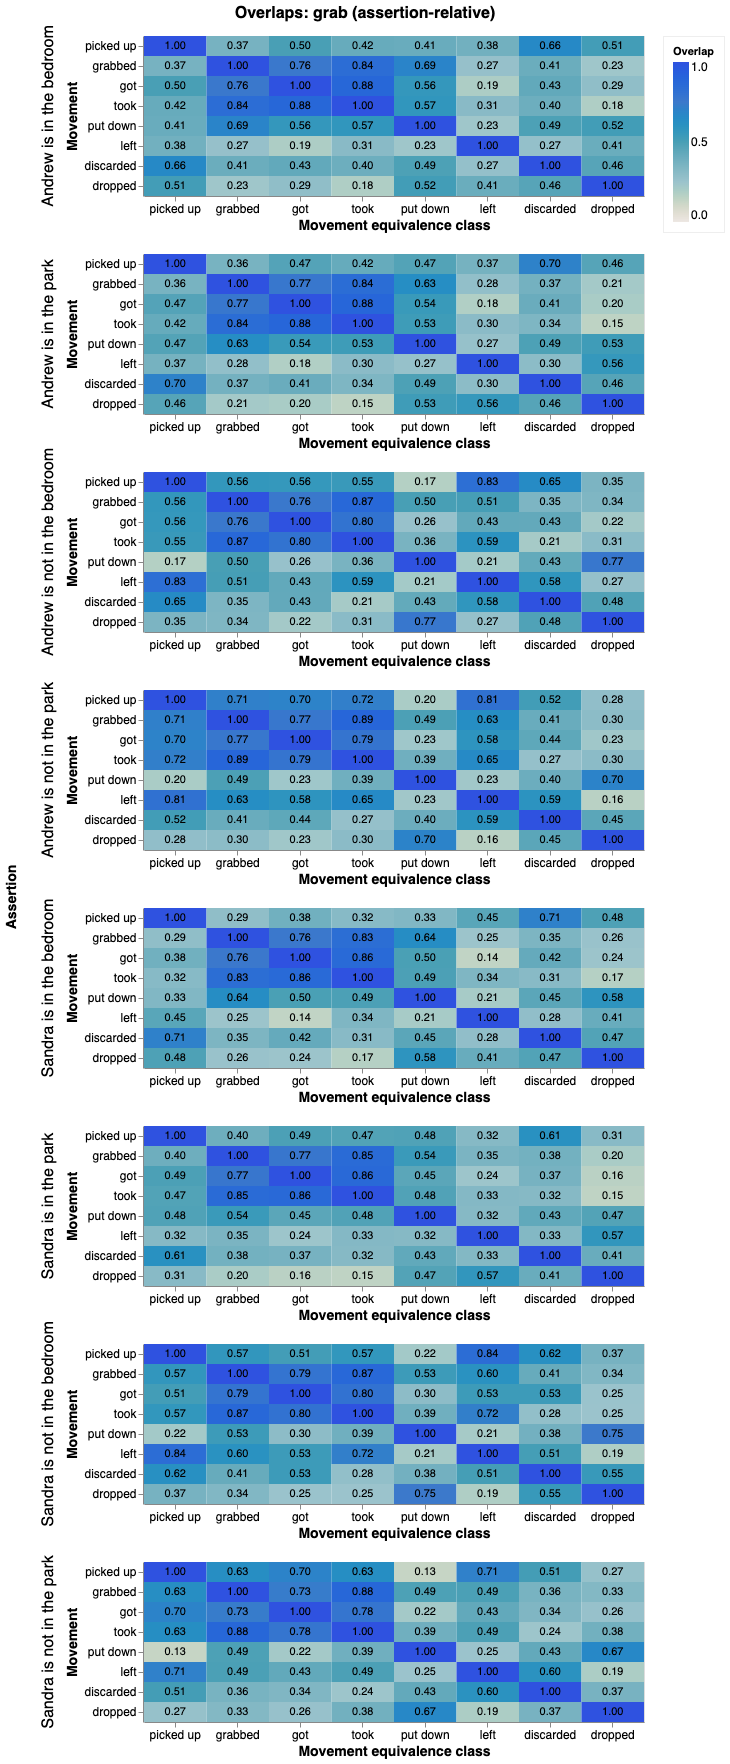

In [205]:
VegaLite({
    "data": {"values": grab_overlaps_ques_df.loc[:, ["grab", "grab2", "overlap_real", "ques"]].to_dict("records")},
    "transform": [
        {"as":"overlap_real_rounded", "calculate": "format(datum.overlap_real, '.2f')"},
        # {"filter": "indexof(['picked up', 'took', 'got'], datum.grab) < 0"},
    ],
    "title": {"text": "Overlaps: grab (assertion-relative)"},
    "facet": {
        "row": {"field": "ques", "title": "Assertion"},
    },
    "columns": 1,
    "resolve": {"axis": {"x": "independent"}},
    "spec": {
        "width": 500,
        "height": 160,
        "encoding": {
            "x": {"field": "grab", "title": "Movement equivalence class", "type": "nominal", "axis": {"labelAngle": 0}, "sort": [
                "Ak", "Cp", "Ap_Ak",
            ]},
            "y": {"field": "grab2", "title": "Movement", "type": "nominal", "sort": [
                "Ak", "Cp", "Ap_Ak",
            ]},
        },
        "layer": [
            {
                "mark": "rect",
                "encoding": {
                    "color": {
                        "field": "overlap_real", 
                        "type": "quantitative", 
                        "title": "Overlap", 
                        "scale": {
                            "domain": [0,1],
                            "scheme": [
                                "#EDE7E3",
                                "#9BC3CC",
                                "#489FB5",
                                "#3C79CB",
                                "#2F52E0",
                            ]
                        },
                    },
                }
            },
            {
                "mark": "text",
                "encoding": {
                    "text": {"field": "overlap_real_rounded"},
                }
            },
        ],
    },
    "config": config,
})

In [206]:
grab_basis = [
    "picked up", "grabbed", 
    "put down", "left", "discarded", "dropped"
]
# grab_basis = grab_boxes.keys()

Here, we inspect the axiom overlaps. We summarise here the expected outcomes for an ideal model.

**Base cases**
- (ID) *Negative base case*: expect high overlap with the negative assertion but not the positive one.
- (Ap) *Positive base case*: expect high overlap with the positive assertion but not the negative one.
- (Ao) *Second negative base case*: expect high overlap with the negative assertion but not the positive one.

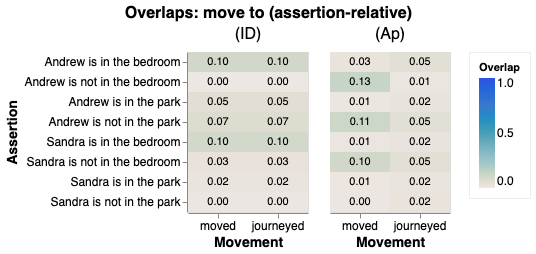

In [215]:
VegaLite({
    "data": {"values": all_axioms_overlaps_df.loc[
        [s in ["(init_k, ID)", "(init_k, Ap)"] for s in all_axioms_overlaps_df.states], 
        ["diag1", "diag2", "overlap_real", "ques", "movement", "movement2", "axiom", "states", "person", "location"]
    ].to_dict("records")},
    "transform": [
        {"as":"states", "calculate": "datum.states === '(init_k, ID)' ? '(ID)' : datum.states"},
        {"as":"states", "calculate": "datum.states === '(init_k, Ap)' ? '(Ap)' : datum.states"},
        # Must readjust mixed states to account for extra factor of 2.
        {"as":"overlap_real", "calculate": "indexof(['(ID)', '(Ap)', '(Ao)'], datum.states) < 0 ? datum.overlap_real / 2 : datum.overlap_real"},
        {"as":"overlap_real_rounded", "calculate": "format(datum.overlap_real, '.2f')"},
    ],
    "title": "Overlaps: move to (assertion-relative)",
    "facet": {"field": "states", "title": "", "sort": ["(ID)", "(Ap)"]},
    "spec": {
        "width": 120,
        "encoding": {
            "x": {"field": "movement", "title": "Movement", "type": "nominal", "axis": {"labelAngle": 0}, "sort": []},
            "y": {"field": "ques", "title": "Assertion", "type": "nominal", "sort": []},
        },
        "layer": [
            {
                "mark": "rect",
                "encoding": {
                    "color": {
                        "field": "overlap_real", 
                        "type": "quantitative", 
                        "title": "Overlap", 
                        "legend": {
                            "gradientLength": 110,
                        },
                        "scale": {
                            "domain": [0,1],
                            "scheme": [
                                "#EDE7E3",
                                "#9BC3CC",
                                "#489FB5",
                                "#3C79CB",
                                "#2F52E0",
                            ]
                        },
                    },
                }
            },
            {
                "mark": "text",
                "encoding": {
                    "text": {"field": "overlap_real_rounded"},
                }
            },
        ],
    },
    "config": config,
})

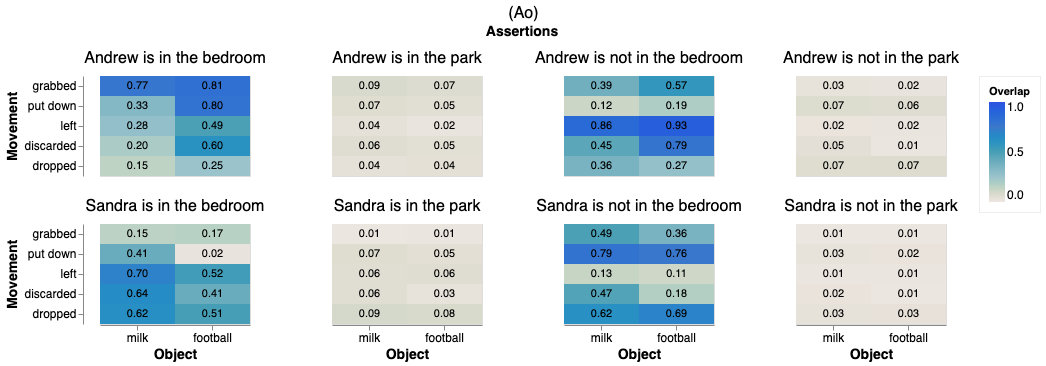

In [218]:
VegaLite({
    "data": {"values": all_axioms_overlaps_df.loc[:, ["diag1", "diag2", "overlap_real", "ques", "movement", "movement2", "axiom"]].to_dict("records")},
    "transform": [
        {"filter": "datum.axiom === 'Base: A is not in p II'"},
        {"filter": f"indexof({grab_basis}, datum.movement2) > 0"},
        {"as":"overlap_real_rounded", "calculate": "format(datum.overlap_real, '.2f')"},
    ],
    "title": {"text": f"(Ao)", "fontWeight": "normal"},
    "facet": {"field": "ques", "title": "Assertions"},
    "columns": 4,
    "spec": {
        "width": 150,
        "encoding": {
            "y": {"field": "movement2", "title": "Movement", "type": "nominal", "axis": {"labelAngle": 0}, "sort": [
                "Ak", "Cp", "Ap_Ak",
            ]},
            "x": {"field": "movement", "title": "Object", "type": "nominal", "axis": {"labelAngle": 0}, "sort": [
                "Ak", "Cp", "Ap_Ak",
            ]},
        },
        "layer": [
            {
                "mark": "rect",
                "encoding": {
                    "color": {
                        "field": "overlap_real", 
                        "type": "quantitative", 
                        "title": "Overlap", 
                        "scale": {
                            "domain": [0,1],
                            "scheme": [
                                "#EDE7E3",
                                "#9BC3CC",
                                "#489FB5",
                                "#3C79CB",
                                "#2F52E0",
                            ]
                        },
                    },
                }
            },
            {
                "mark": "text",
                "encoding": {
                    "text": {"field": "overlap_real_rounded"},
                }
            },
        ],
    },
    "config": config,
})

For the following, we compute the assertion relative overlap between the two given states.

**Singletons**
- (Ap, ID) *Moving matters*: expect low overlaps
- (Ap, Ak) *Distinguishable locations*: expect low overlaps
- (Ap, Cp) *Distinguishable people*: expect low overlaps

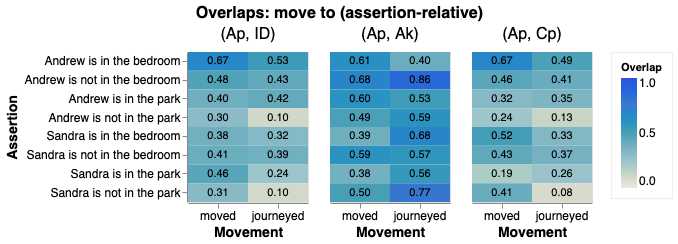

In [209]:
VegaLite({
    "data": {"values": all_axioms_overlaps_df.loc[
        [s in ["(Ap, ID)", "(Ap, Ak)", "(Ap, Cp)"] for s in all_axioms_overlaps_df.states], 
        ["diag1", "diag2", "overlap_real", "ques", "movement", "movement2", "axiom", "states"]
    ].to_dict("records")},
    "transform": [
        {"as":"states", "calculate": "datum.states === '(init_b, ID)' ? '(ID)' : datum.states"},
        {"as":"states", "calculate": "datum.states === '(init_b, Ap)' ? '(Ap)' : datum.states"},
        # Must readjust mixed states to account for extra factor of 2.
        {"as":"overlap_real", "calculate": "indexof(['(ID)', '(Ap)', '(Ao)'], datum.states) < 0 ? datum.overlap_real / 2 : datum.overlap_real"},
        {"as":"overlap_real_rounded", "calculate": "format(datum.overlap_real, '.2f')"},
    ],
    "title": "Overlaps: move to (assertion-relative)",
    "facet": {"field": "states", "title": "", "sort": [
        "(Ap, ID)", "(Ap, Ak)", "(Ap, Cp)"
    ]},
    "columns": 3,
    "spec": {
        "width": 120,
        "height": 150,
        "encoding": {
            "x": {"field": "movement", "title": "Movement", "type": "nominal", "axis": {"labelAngle": 0}, "sort": [
                "Ak", "Cp", "Ap_Ak",
            ]},
            "y": {"field": "ques", "title": "Assertion", "type": "nominal", "sort": [
                "Ak", "Cp", "Ap_Ak",
            ]},
        },
        "layer": [
            {
                "mark": "rect",
                "encoding": {
                    "color": {
                        "field": "overlap_real", 
                        "type": "quantitative", 
                        "title": "Overlap", 
                        "legend": {
                            "gradientLength": 110,
                        },
                        "scale": {
                            "domain": [0,1],
                            "scheme": [
                                "#EDE7E3",
                                "#9BC3CC",
                                "#489FB5",
                                "#3C79CB",
                                "#2F52E0",
                            ]
                        },
                    },
                }
            },
            {
                "mark": "text",
                "encoding": {
                    "text": {"field": "overlap_real_rounded"},
                }
            },
        ],
    },
    "config": config,
})

**Extra location**
- (Ak_Ap, Ap_Ak) *Visit ordering*: expect low overlaps
- (Ak_Ap, Ap) *Forgetfulness (locations)*: expect high overlaps

**Extra person**
- (Cp_Ap, Ap_Cp) *Arrival order*: expect high overlaps
- (Ap, Ap_Cp) *Forgetfulness (other people)*: expect high overlaps

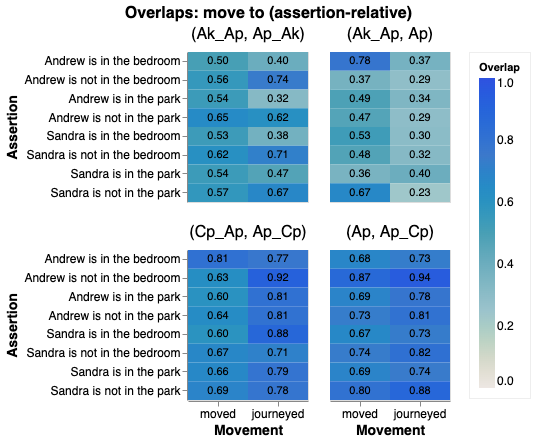

In [212]:
VegaLite({
    "data": {"values": all_axioms_overlaps_df.loc[
        [s in ["(Ak_Ap, Ap_Ak)", "(Ak_Ap, Ap)", "(Cp_Ap, Ap_Cp)", "(Ap, Ap_Cp)"] for s in all_axioms_overlaps_df.states], 
        ["diag1", "diag2", "overlap_real", "ques", "movement", "movement2", "axiom", "states"]
    ].to_dict("records")},
    "transform": [
        {"as":"states", "calculate": "datum.states === '(init_b, ID)' ? '(ID)' : datum.states"},
        {"as":"states", "calculate": "datum.states === '(init_b, Ap)' ? '(Ap)' : datum.states"},
        # Must readjust mixed states to account for extra factor of 2.
        {"as":"overlap_real", "calculate": "indexof(['(ID)', '(Ap)', '(Ao)'], datum.states) < 0 ? datum.overlap_real / 2 : datum.overlap_real"},
        {"as":"overlap_real_rounded", "calculate": "format(datum.overlap_real, '.2f')"},
    ],
    "title": "Overlaps: move to (assertion-relative)",
    "facet": {"field": "states", "title": "", "sort": [
        "(Ak_Ap, Ap_Ak)", "(Ak_Ap, Ap)", "(Cp_Ap, Ap_Cp)", "(Ap, Ap_Cp)"
    ]},
    "columns": 2,
    "spec": {
        "width": 120,
        "height": 150,
        "encoding": {
            "x": {"field": "movement", "title": "Movement", "type": "nominal", "axis": {"labelAngle": 0}, "sort": [
                "Ak", "Cp", "Ap_Ak",
            ]},
            "y": {"field": "ques", "title": "Assertion", "type": "nominal", "sort": [
                "Ak", "Cp", "Ap_Ak",
            ]},
        },
        "layer": [
            {
                "mark": "rect",
                "encoding": {
                    "color": {
                        "field": "overlap_real", 
                        "type": "quantitative", 
                        "title": "Overlap", 
                        "legend": {
                            "gradientLength": 310,
                        },
                        "scale": {
                            "domain": [0,1],
                            "scheme": [
                                "#EDE7E3",
                                "#9BC3CC",
                                "#489FB5",
                                "#3C79CB",
                                "#2F52E0",
                            ]
                        },
                    },
                }
            },
            {
                "mark": "text",
                "encoding": {
                    "text": {"field": "overlap_real_rounded"},
                }
            },
        ],
    },
    "config": config,
})

**Extra object**
- (Ap_Ao, Ao_Ap) *Teleporting objects*: expect high overlaps
- (Ap, Ao_Ap) *Forgetfulness (objects)*: expect high overlaps

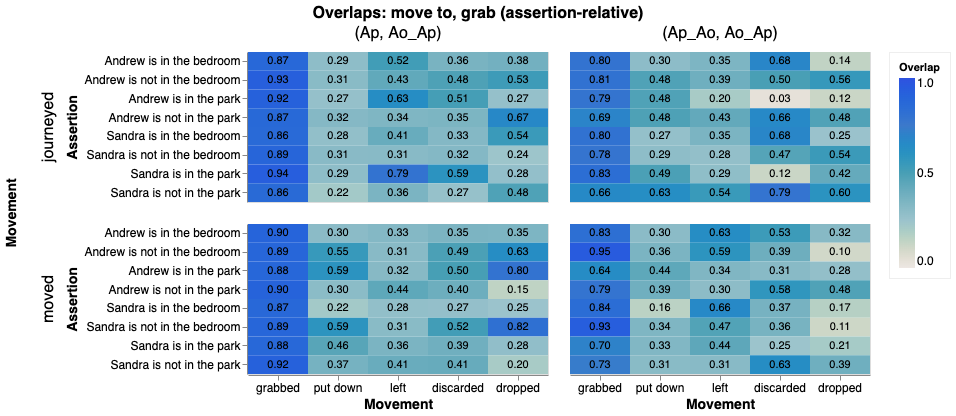

In [222]:
VegaLite({
    "data": {"values": all_axioms_overlaps_df.loc[:, ["diag1", "diag2", "overlap_real", "ques", "movement", "movement2", "axiom", "states"]].to_dict("records")},
    "transform": [
        {"filter": "datum.axiom === 'irrelevance' || datum.axiom === 'commutativitiy'"},
        {"filter": "datum.states !== '(Ap, Ap_Ao)'"},
        {"filter": f"indexof({grab_basis}, datum.movement2) > 0"},
        {"as":"overlap_real", "calculate": "indexof(['(Ap, ID)', '(init_b, ID)', '(init_b, Ap)', '(Ap, Ap_Ap)'], datum.states) < 0 ? datum.overlap_real / 2 : datum.overlap_real"},
        {"as":"overlap_real_rounded", "calculate": "format(datum.overlap_real, '.2f')"},
    ],
    "title": "Overlaps: move to, grab (assertion-relative)",
    "facet": {
        "row": {"field": "movement", "title": "Movement"},
        "column": {"field": "states", "title": false},
    },
    "columns": 1,
    "spec": {
        "width": 300,
        "height": 150,
        "encoding": {
            "x": {"field": "movement2", "title": "Movement", "type": "nominal", "axis": {"labelAngle": 0}, "sort": []},
            "y": {"field": "ques", "title": "Assertion", "type": "nominal", "sort": []},
        },
        "layer": [
            {
                "mark": "rect",
                "encoding": {
                    "color": {
                        "field": "overlap_real", 
                        "type": "quantitative", 
                        "title": "Overlap", 
                        "legend": {"gradientLength": 190},
                        "scale": {
                            "domain": [0,1],
                            "scheme": [
                                "#EDE7E3",
                                "#9BC3CC",
                                "#489FB5",
                                "#3C79CB",
                                "#2F52E0",
                            ]
                        },
                    },
                }
            },
            {
                "mark": "text",
                "encoding": {
                    "text": {"field": "overlap_real_rounded"},
                }
            },
        ],
    },
    "config": config,
})

## Assertions

For the assertions, we only care about the overlap between the positive and negative assertions relating to the same nouns. While it is not required for the overlaps to be low, a low overlap gives the model bigger error margins, as the final answer is ultimately relative to the basis formed by the pair of assertions.

In [249]:
question_overlaps = (
    (
        ques, ques2, 
        torch.abs(torch.square(lambdeval(question["diag"] >> question2["diag"].dagger()))), 
        question["person"], question["location"]
    )
    for ques, question in tqdm(questions.items())
    for ques2, question2 in questions.items()
    if question["person"] == question2["person"]
    and question["location"] == question2["location"]
    and question["is_in"] and not question2["is_in"]
)
question_overlaps_df = pd.DataFrame(question_overlaps, columns=["question1", "question2", "overlap", "person", "location"])
question_overlaps_df["overlap_real"] = [o.real.item() for o in question_overlaps_df.overlap]
question_overlaps_df["title"] = [
    f"({s1}, {s2})"
    for s1, s2 in zip(question_overlaps_df.person, question_overlaps_df.location)
]
question_overlaps_df = question_overlaps_df.drop_duplicates()

question_overlaps_df.to_csv(SAVE_DIR / f"question_overlaps.csv")

question_overlaps_df

100%|██████████| 8/8 [00:00<00:00, 70.72it/s]


,question1,question2,overlap,person,location,overlap_real,title
0,Andrew is in the bedroom,Andrew is not in the bedroom,"tensor(0.3473, dtype=torch.float64)",Andrew,bedroom,0.347327,"(Andrew, bedroom)"
1,Andrew is in the park,Andrew is not in the park,"tensor(0.4369, dtype=torch.float64)",Andrew,park,0.436858,"(Andrew, park)"
2,Sandra is in the bedroom,Sandra is not in the bedroom,"tensor(0.2392, dtype=torch.float64)",Sandra,bedroom,0.239194,"(Sandra, bedroom)"
3,Sandra is in the park,Sandra is not in the park,"tensor(0.5614, dtype=torch.float64)",Sandra,park,0.561386,"(Sandra, park)"


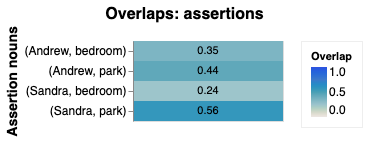

In [259]:
VegaLite({
    "data": {"values": question_overlaps_df.loc[:, ["question1", "question2", "overlap_real", "title"]].to_dict("records")},
    "transform": [
        {"as":"overlap_real_rounded", "calculate": "format(datum.overlap_real, '.2f')"},
    ],
    "title": "Overlaps: assertions",
        "width": 150,
        "encoding": {
            "y": {"field": "title", "title": "Assertion nouns", "type": "nominal", "axis": {"labelAngle": 0}, "sort": []},
        },
        "layer": [
            {
                "mark": "rect",
                "encoding": {
                    "color": {
                        "field": "overlap_real", 
                        "type": "quantitative", 
                        "title": "Overlap", 
                        "legend": {"gradientLength": 50},
                        "scale": {
                            "domain": [0,1],
                            "scheme": [
                                "#EDE7E3",
                                "#9BC3CC",
                                "#489FB5",
                                "#3C79CB",
                                "#2F52E0",
                            ]
                        },
                    },
                }
            },
            {
                "mark": "text",
                "encoding": {
                    "text": {"field": "overlap_real_rounded"},
                }
            },
        ],
    # },
    "config": config,
})